In [1]:
import tensorflow as tf
tf.reset_default_graph()
sess = tf.InteractiveSession()
import keras as k
import os
from glob import glob
import re
import numpy as np

Using TensorFlow backend.


In [2]:
!pwd
os.chdir('/home/ubuntu/txt')


/home/ubuntu


In [3]:
langs = glob('*')
data = []
for lang in langs:
    os.chdir(lang)
    files = glob('*')
    counter = 0
    for file in files:
        with open(file) as f:
            temp = f.readlines()
            for line in temp:
                if line[0] != '<':
                        line = re.sub(r'\([CLPNRFHEISDB][GKLNRVEUAISTO]\)', '', line)    #remove speaker lang annotantions
                        line = re.sub(r'[\xad\xa0\u200b\u202c\u202e\u202a\u202d�]', '', line) #remove invisible chars
                        if line[0] != '(':
                            if re.search(r'[眠舃舣脘舉]', line) == None:  #drop sentences with chinese chars
                                if line[0].isupper() == False:   #try to fix lines which start with lowercase
                                    temp2 = line.strip().split('. ')
                                    if len(temp2) > 1:
                                        line = ''.join([x + '. ' if i != len(temp2) -2 else x for i,x in enumerate(temp2[1:]) ])
                                if line[0].isupper() and len(line) > 10 and len(line) < 300:
                                    data.append((lang, line.strip()))
    os.chdir('..')


In [4]:
np.random.shuffle(data)
np.random.shuffle(data)
print(len(data))
unique_letters = set()
for i in range(len(data)):
    unique_letters.update(set(data[i][1]))

2981374


In [5]:
train = data[:2000000] #2kk train
val = data[2000000:2500000] #500K validation
test = data[2500000:]
del data
keys_to_letters = dict(zip(range(len(unique_letters)), list(unique_letters)))
letters_to_keys = {val:key for key,val in keys_to_letters.items()}
punctuation = [key for key, item in keys_to_letters.items() if item in [' ', '.', ','] ]
key_to_lang = dict(zip(range(len(langs)), langs))
lang_to_key = {val:key for key,val in key_to_lang.items()}


In [6]:
def letter_to_onehot(letter):
    return np.eye(LETTERS_NUM)[letters_to_keys[letter]]

def letter_from_onehot(vec):
    idx = np.argmax(vec)
    return keys_to_letters[idx]

In [7]:

LETTERS_NUM = len(unique_letters)
LANGS_NUM = len(langs)

INPUT_WINDOW_SIZE = 10

In [8]:
index_train = 0
index_val = 0
index_test = 0
def gen_data(idx, mode='train',):
    gen_data = []
    lang_n = -1
    letter = []
    punct = []
    real = []
    gan = 0
    data_onehot = []

        
    if mode =='train':
        lang, gen_data = train[idx]
        data_onehot = [letter_to_onehot(x) for x in gen_data]
    elif mode == 'validation':
        lang, gen_data = val[idx]
        data_onehot = [letter_to_onehot(x) for x in gen_data]
    else:
        lang, gen_data = test[idx]
        
        data_onehot = [letter_to_onehot(x) for x in gen_data]
        #make frames of data
    
    n_frames = len(gen_data) - INPUT_WINDOW_SIZE + 1
    
        
    input_frames = []
    #np.zeros((n_frames, INPUT_WINDOW_SIZE*LETTERS_NUM))
    lang = [np.eye(LANGS_NUM)[lang_to_key[lang]] for _ in range(n_frames)]
    #np.ones((n_frames,LANGS_NUM)) * np.eye(LANGS_NUM)[lang_to_key[lang]]
    
    for i in range(n_frames):
        input_frames.append(np.concatenate(data_onehot[i: i+INPUT_WINDOW_SIZE], axis=0))
            
        
        
    return input_frames, lang

In [9]:
a,b = gen_data(1, mode='validation')
print(len(a[0]))
print(len(a))

4180
281


In [13]:
def simple():
    
    inputs = k.Input(batch_shape=(1, LETTERS_NUM*INPUT_WINDOW_SIZE))
    encode = k.layers.Dense(128, activation='elu')(inputs)
    reshape = k.layers.Reshape((1,-1))(encode)
    lstm1 = k.layers.LSTM(128, activation='elu', recurrent_activation='tanh', return_sequences=True, stateful=True)(reshape)
    lstm2 = k.layers.LSTM(128, activation='tanh', recurrent_activation='tanh', return_sequences=True, stateful=True)(lstm1)
    preout = k.layers.TimeDistributed(k.layers.Dense(64, activation='elu'))(lstm2)
    out = k.layers.Dense(LANGS_NUM, activation='softmax')(preout)
    
    model = k.models.Model(inputs=inputs, outputs=out)
    adam = k.optimizers.Adam(lr=3e-4)#, amsgrad=True)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    model.summary()
    return model

lang4 = simple()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (1, 4180)                 0         
_________________________________________________________________
dense_4 (Dense)              (1, 128)                  535168    
_________________________________________________________________
reshape_2 (Reshape)          (1, 1, 128)               0         
_________________________________________________________________
lstm_3 (LSTM)                (1, 1, 128)               131584    
_________________________________________________________________
lstm_4 (LSTM)                (1, 1, 128)               131584    
_________________________________________________________________
time_distributed_2 (TimeDist (1, 1, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (1, 1, 21)                1365      
Total para

In [14]:
def data_generator(n, mode='train'):
    if mode=='validation':
        while True:
            n = np.random.randint(0,len(val))
            temp = gen_data(n, mode=mode)
            
            for q in range(len(temp[0])):
                yield tuple((np.array([temp[0][q]]), np.array([[temp[1][q]]])))
    elif mode=='train':
        temp = gen_data(n, mode=mode)
        for q in range(len(temp[0])):
                yield tuple((np.array([temp[0][q]]), np.array([[temp[1][q]]])))
        


import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display



class History(k.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.acc = []
        self.loss = []
    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.acc.append(logs.get('acc'))
        
        
        
        return

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        self.loss.append(logs.get('loss'))

        return
callback = History()


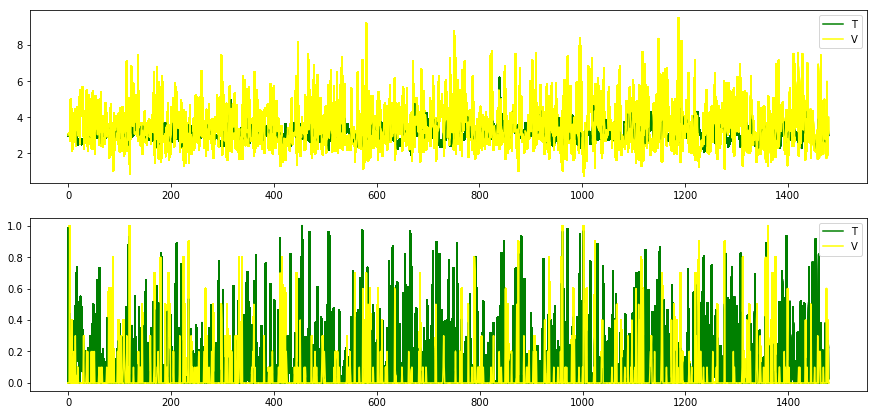

In [ ]:
fig, axs = plt.subplots(2,1, figsize=(15,7))

train_loss_hist = [3]
val_loss_hist = [3]
train_acc_hist = []
val_acc_hist = []
train_len = len(train)//1000
for i in range(train_len):
    validate = None
    rand_index = np.random.randint(0, train_len)
    n_steps = np.array(np.array(gen_data(rand_index)).shape[1])
    #if i%100 == 0:
    validate = data_generator(1, mode='validation')
    train_gen = data_generator(rand_index)
    hist = lang4.fit_generator(train_gen, steps_per_epoch=n_steps, epochs=1, verbose=0, \
                             validation_data=validate, validation_steps=10, \
                             shuffle=False)
    lang4.reset_states()
    if validate != None:

        train_loss_hist.append(train_loss_hist[-1]*0.8 + 0.2*(hist.history['loss'][0]))
        train_acc_hist.append(hist.history['acc'][0])
        val_loss_hist.append(hist.history['val_loss'][0])
        val_acc_hist.append(hist.history['val_acc'][0])
        axs[0].plot(train_loss_hist, color='green')
        axs[0].plot(val_loss_hist,color='yellow')
        axs[0].legend("TV",loc="upper right")
        axs[1].plot(train_acc_hist,color='green')
        axs[1].plot(val_acc_hist, color='yellow')
        axs[1].legend("TV",loc="upper right")
        display.clear_output(wait=True)
        display.display(plt.gcf())

#### Appanrently, keras stateful lstm does NOT backprob between subsequent inputs, only state is preserved.
#### And training is also very slow (backprob through a paragraph and evaluation takes ~2 seconds)

Don't have time to tune learning rate, choose optimizer, or number of layers/neurons

Should've probably considered more orthodox approach with splitting the paragraphs into sentences and padding, to train in batches.
